# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Simple-line-fit-with-MCMC" data-toc-modified-id="Simple-line-fit-with-MCMC-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple line fit with MCMC</a></div><div class="lev1 toc-item"><a href="#Model:-a-line-mx-+-b" data-toc-modified-id="Model:-a-line-mx-+-b-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model: a line <em>mx + b</em></a></div><div class="lev1 toc-item"><a href="#prior" data-toc-modified-id="prior-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>prior</a></div><div class="lev1 toc-item"><a href="#likelihood" data-toc-modified-id="likelihood-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>likelihood</a></div><div class="lev1 toc-item"><a href="#DYI-Metropolis-Hasting" data-toc-modified-id="DYI-Metropolis-Hasting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>DYI Metropolis Hasting</a></div><div class="lev2 toc-item"><a href="#Run-the-code-with-different-chain-lengths-to-see-how-the-MCMC-explores-the-parameter-space" data-toc-modified-id="Run-the-code-with-different-chain-lengths-to-see-how-the-MCMC-explores-the-parameter-space-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Run the code with different chain lengths to see how the MCMC explores the parameter space</a></div><div class="lev1 toc-item"><a href="#Affine-Invariant-MCMC-sample-(with-emcee)" data-toc-modified-id="Affine-Invariant-MCMC-sample-(with-emcee)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Affine Invariant MCMC sample (with emcee)</a></div><div class="lev1 toc-item"><a href="#Comparison-with-analytical-solution" data-toc-modified-id="Comparison-with-analytical-solution-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Comparison with analytical solution</a></div><div class="lev1 toc-item"><a href="#Test-convergence-by-looking-at-the-autocorrelation" data-toc-modified-id="Test-convergence-by-looking-at-the-autocorrelation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Test convergence by looking at the autocorrelation</a></div><div class="lev1 toc-item"><a href="#Increase-the-steps-in-the-chain" data-toc-modified-id="Increase-the-steps-in-the-chain-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Increase the steps in the chain</a></div>

# Simple line fit with MCMC

In [2]:
from __future__ import print_function, division
import pylab as pl
import  corner
import emcee
import scipy
from scipy.stats import norm as spnorm

%pylab inline

pl.rcParams['figure.figsize']= (10,10)
pl.rcParams['font.size'] = 18

Populating the interactive namespace from numpy and matplotlib


# Model: a line *mx + b*

In [4]:
def line(m, b, x):
    return m * x + b

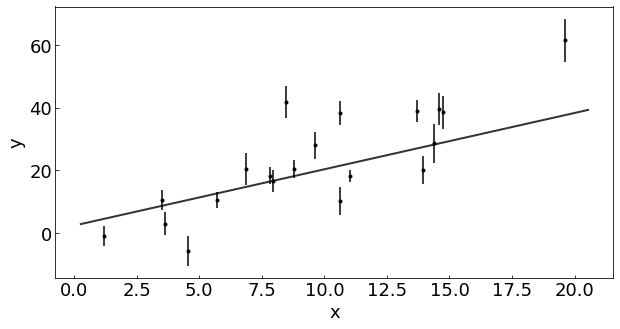

Figure 1: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors


In [6]:
# Choose the "true" parameters.
m_true = 1.8
b_true = 2.3

# Generate some synthetic data from the model.
N = 20
np.random.seed(123)
x = np.sort(np.random.rand(N) * 20)
y = line(m_true, b_true, x)
yerr = np.sqrt(y) + np.random.randn(N) 
y += yerr * np.random.randn(N) * 2

ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-', alpha=0.8, lw=2)

pl.show()
print ("Figure 1: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors")

To get 

$P(\theta \mid D,f)$

from Bayes theorem

$P(\theta \mid D,f)\quad \propto { { \quad P(D\mid \theta ,f)\, P(\theta ,f) } } $

I need $ { { \quad P(D\mid \theta ,f)\, P(\theta ,f) } } $ 

NEXT STEP: define Prior $ P(\theta ,f)$ and Likelihood $\quad P(D\mid \theta ,f)$

# prior

In [7]:
# what do I know about my model? e.g. the slope should be between 0 and 90 degree
def lnprior(theta):
    m, b = theta
    if -10 < b < 10 and 0 < m < 10 :
        return 0.0
    return -np.inf

# likelihood

In [8]:
#remember the chi square: 
# Sum((model - data)/error)^2 is a quantity that follows a chi square distribution with N=number of degreed of freedom. 
# Divide it by the number of degreed  of freedom as Chisq = (Sum((model - data)/error)^2)/DOF
# If it is ~1 that is a good model. 
# >1 bad model
# <1 your errors must be underestimated (model too good to be true!)

def lnlike(theta, x, y, yerr):
    m, b = theta
    return -0.5*(np.sum((line(m, b, x) - y)**2 / (yerr**2)))

# DYI Metropolis Hasting 

In [9]:
np.random.seed(666)

theta_current = (m_true, b_true) + np.random.randn(2)

# we start the walk here
walk = [theta_current]

# propoed perturbation of the current position - gaussian with width 0.5
proposal_width = (0.2, 0.2) 
proposal = spnorm(theta_current, proposal_width).rvs()

# current values  of the pieces of Bayes theorem
ln_current = lnlike(theta_current, x, y, yerr)
prior_current = lnprior(theta_current)

# values  of the pieces of Bayes theorem at the proposed position
ln_proposal  = lnlike(proposal, x, y, yerr)
prior_proposal = lnprior(proposal)

# put them together
p_current = np.exp(ln_current + prior_current)
p_proposal = np.exp(ln_proposal + prior_proposal)


## Run the code with different chain lengths to see how the MCMC explores the parameter space
The simple algorithm coded below runs an MCMC with a single chain. The length of the chain is controlled by the parameter N


In [23]:
N = 10000 #number of steps in my chain

# move along the walk N = 100, 1000 steps
np.random.seed(666)

theta_current = (m_true, b_true) + np.random.randn(2)

# we start the walk here
walk = [theta_current]

# propoed perturbation of the current position - gaussian with width 0.5
proposal_width = (0.2, 0.2) 
proposal = spnorm(theta_current, proposal_width).rvs()

# current values  of the pieces of Bayes theorem
ln_current = lnlike(theta_current, x, y, yerr)
prior_current = lnprior(theta_current)

# values  of the pieces of Bayes theorem at the proposed position
ln_proposal  = lnlike(proposal, x, y, yerr)
prior_proposal = lnprior(proposal)

# put them together
p_current = np.exp(ln_current + prior_current)
p_proposal = np.exp(ln_proposal + prior_proposal)

for i in range(N):
    
    # calculate the proposal and the prior  and likelihood there
    proposal = spnorm(theta_current, proposal_width).rvs()
    ln_proposal  = lnlike(proposal, x, y, yerr)
    prior_proposal = lnprior(proposal)
    p_proposal = np.exp(ln_proposal + prior_proposal)
    
    # update for sure if it is a better location
    if p_proposal > p_current:
        #print ("right away")
        theta_current, ln_current, prior_current, p_current = \
        proposal, ln_proposal, prior_proposal, p_proposal
        walk.append(proposal)
        
    #update with a probability equal to the posteriors ratio if the location is worse
    else:
        p_accept = (p_proposal / p_current)
        
        #use a stocastic draw to accept with probability P
        if np.random.rand() < p_accept:
            #print ("later on away")

            theta_current, ln_current, prior_current, p_current = proposal, ln_proposal, prior_proposal, p_proposal
            walk.append(proposal)
m_mcmc = np.percentile(np.array(walk)[:,0], [50, 16, 84])
b_mcmc = np.percentile(np.array(walk)[:,1], [50, 16, 84])
mcmcRes = np.concatenate([m_mcmc, b_mcmc])
print ("MCMC result:\nslope\t\t{0:+.2f} ({1:.2f}, {2:.2f})\nintercept\t{3:.2f} ({4:.2f}, {5:.2f})".format(*mcmcRes))

MCMC result:
slope		+2.69 (2.52, 2.84)
intercept	-4.42 (-5.58, -2.79)


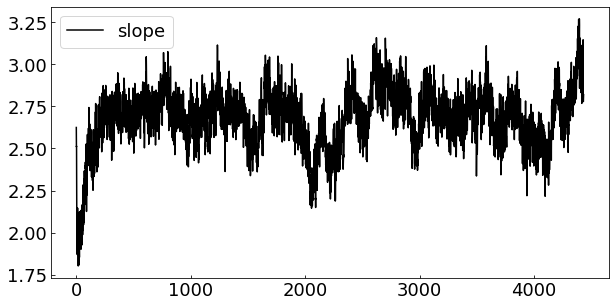

Fig 2:  slope MCMC chain


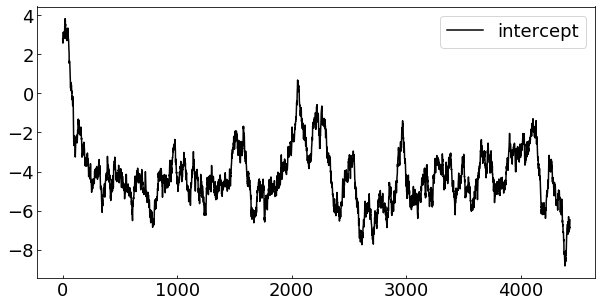

Fig 3:  intercept MCMC chain


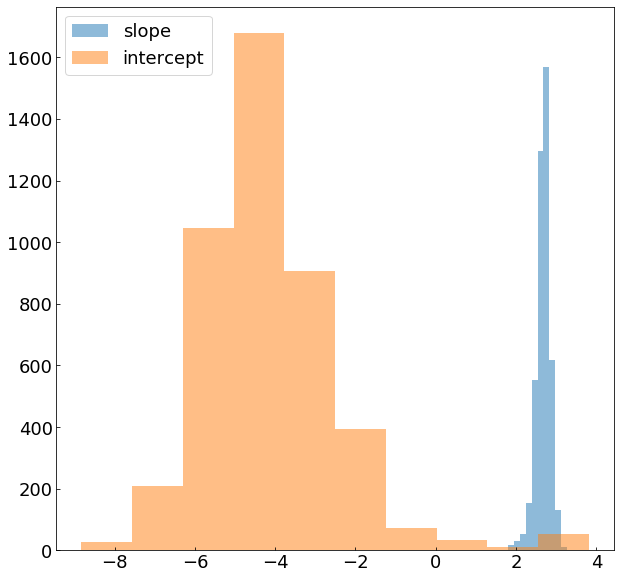

Fig 4:  slope and intercept MCMC posterior distributions


In [24]:
# look at the sampled posterior  space
pl.figure(figsize=(10,5))
pl.plot(np.array(walk)[:,0],'k-', label="slope")
pl.legend()
pl.show()
print ("Fig 2:  slope MCMC chain")

pl.figure(figsize=(10,5))
pl.plot(np.array(walk)[:,1], 'k-', label="intercept")
pl.legend()
pl.show()
print ("Fig 3:  intercept MCMC chain")

pl.figure()
pl.hist(np.array(walk)[:,0], alpha=0.5, label="slope")

pl.hist(np.array(walk)[:,1], alpha=0.5, label="intercept")
pl.legend()
pl.show()
print ("Fig 4:  slope and intercept MCMC posterior distributions")


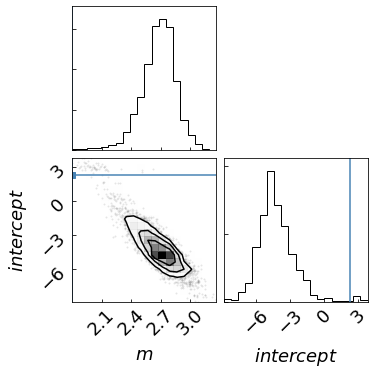

Fig 5: posterior joint distribution


In [27]:
fig = corner.corner(walk, labels=["$m$","$intercept$"],
                   truths=(m_true, b_true))
pl.show()
print ("Fig 5: posterior joint distribution - generative model truth indicated in blue")

# Affine Invariant MCMC sample (with emcee)

The emcee package implements Affine Invariant MCMC in python

http://dan.iel.fm/emcee/current/ 

In [28]:
# ENCEE needs a lnprob function to put together prior and posterior (in log space)
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [35]:
ndim, nwalkers, nsteps = 2, 100, 500
pos = [np.array([m_true, b_true]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, nsteps);

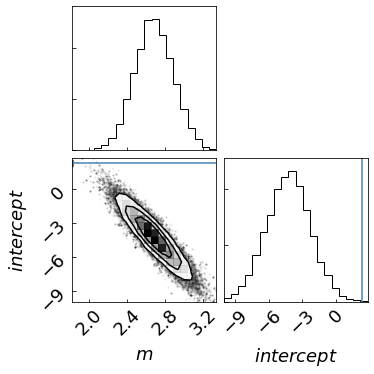

Fig: EMCEE with 100 chains of 100 steps  - generative model truth indicated in blue


In [39]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$","$intercept$"],
                      truths=[m_true, b_true])
pl.show()
print ("Fig 6: EMCEE with {0:d} chains of {0:d} steps  ".format(nwalkers, nsteps) + 
       "- generative model truth indicated in blue")

In [31]:
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [33]:
mcmcRes = np.concatenate([m_mcmc, b_mcmc])
print ("MCMC result:\nslope\t\t{0:+.2f} ({1:.2f}, {2:.2f})\nintercept\t{3:.2f} ({4:.2f}, {5:.2f})".format(*mcmcRes))

MCMC result:
slope		+2.69 (0.20, 0.21)
intercept	-4.25 (1.95, 1.97)


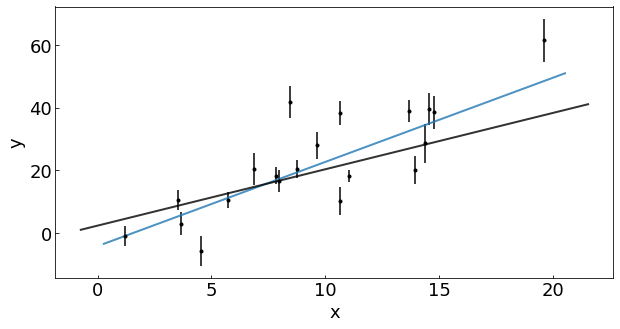

Figure 7: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.
In blue the model with MCMC best fit parameters, identified as the median of the joint posterior distributions, is indicated


In [42]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), 
        '-', alpha=0.8, lw=2, label="generative model")
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 
        'k-', alpha=0.8, lw=2, label="MCMC result")
pl.show()
print ("Figure 7: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.\n" + 
       "In blue the model with MCMC best fit parameters, " + 
       "identified as the median of the joint posterior distributions, is indicated")

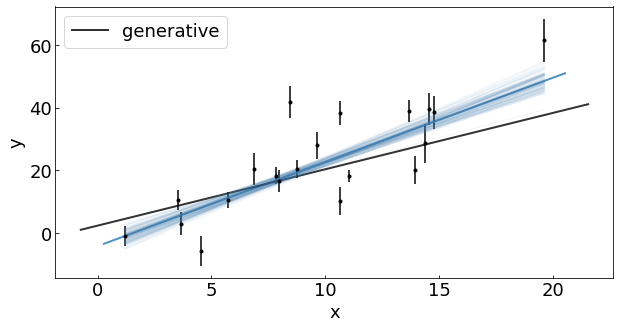

Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.
In blue model with the MCMC best fit parameters, identified as the median of the joint posterior distributions, is indicated.
In light blue shades the model with the best parameters for each chain is plotted


In [44]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), '-', alpha=0.8, lw=2)
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-', 
        alpha=0.8, lw=2, label="generative")
for m, b in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x, m*x+b, color="SteelBlue", alpha=0.05)
ax.legend(loc=2)
pl.show()
print ("Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.\n" + 
       "In blue model with the MCMC best fit parameters, "  + 
       "identified as the median of the joint posterior distributions, is indicated.\n" + 
       "In light blue shades the model with the best parameters for each chain is plotted")

# Comparison with analytical solution

In [45]:
# linear algebra solution
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.
In blue model with the MCMC best fit parameters, identified as the median of the joint posterior distributions, is indicated.
In light blue shades the model with the best parameters for each chain is plotted
In orange the anayltical solution (OLS) is indicated by a dashed line


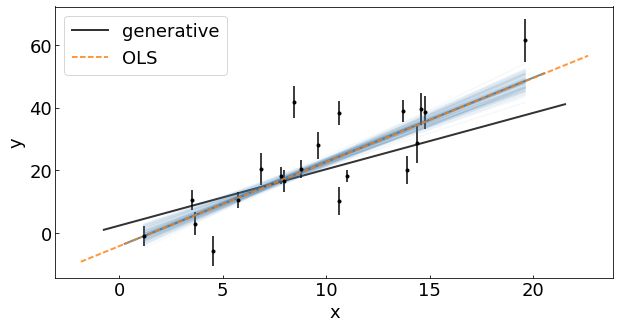

In [46]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), '-', alpha=0.8, lw=2)
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-',
        alpha=0.8, lw=2, label="generative")
for m, b in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x, m*x+b, color="SteelBlue", alpha=0.05)
ax.plot(pl.xlim(), line(m_ls, b_ls,  np.array(pl.xlim())), '--', 
        alpha=0.8, lw=2, label="OLS")
pl.legend();
print ("Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.\n" + 
       "In blue model with the MCMC best fit parameters, "  + 
       "identified as the median of the joint posterior distributions, is indicated.\n" + 
       "In light blue shades the model with the best parameters for each chain is plotted\n" + 
       "In orange the anayltical solution (OLS) is indicated by a dashed line")

In [47]:
pos = [np.array([m_ls, b_ls]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, nsteps);

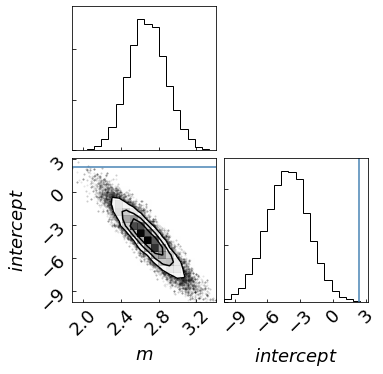

Fig 10: EMCEE with 100 chains of 100 steps  - generative model truth indicated in blue, the starting point was the OLS solution


In [49]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$","$intercept$"],
                      truths=[m_true, b_true])
pl.show()
print ("Fig 10: EMCEE with 100 chains of 100 steps  - generative model truth indicated in blue, the starting point was the OLS solution")


In [50]:
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
mcmcRes = np.concatenate([m_mcmc, b_mcmc])
print ("MCMC result:\nslope\t\t{0:+.2f} ({1:.2f}, {2:.2f})\nintercept\t{3:.2f} ({4:.2f}, {5:.2f})".format(*mcmcRes))

MCMC result:
slope		+2.68 (0.20, 0.20)
intercept	-4.16 (1.88, 1.97)


# Test convergence by looking at the autocorrelation 

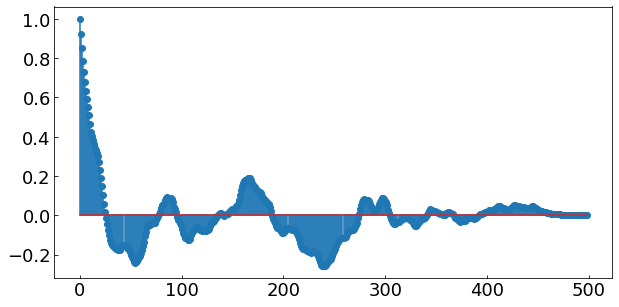

Fig 11: Chain Autocorrelation


In [51]:
def acorr(x):
    ax = pl.figure(figsize=(10,5)).add_subplot(111)

    x = x - x.mean()

    autocorr = np.correlate(x, x, mode='full')
    autocorr = autocorr[x.size:]
    autocorr /= autocorr.max()

    return ax.stem(autocorr)

acorr(sampler.chain[0,:,0])
pl.show()
print ("Fig 11: Chain Autocorrelation")

# Increase the steps in the chain

In [53]:
ndim, nwalkers, nsteps = 2, 100, 1500
pos = [np.array([m_ls, b_ls]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 1500);

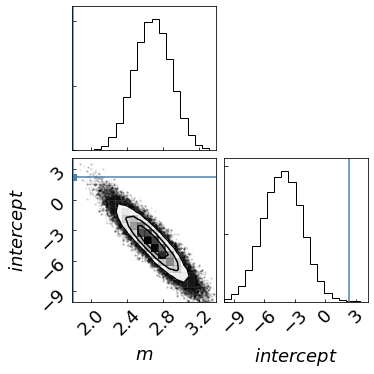

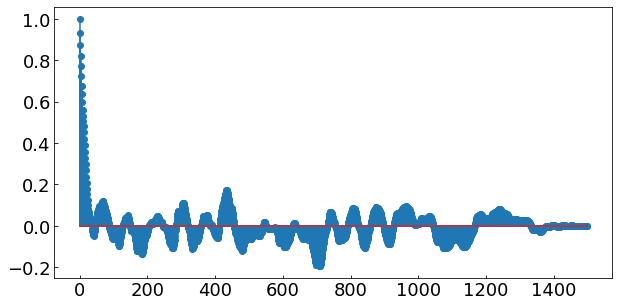

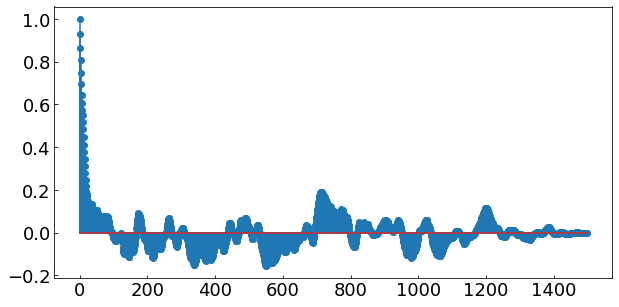

Fig 12: Corner plot showing the joint posterior and chain autocorrelation for 2 longer chain of 1500 steps


In [55]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$","$intercept$"],
                      truths=[m_true, b_true])
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
m_mcmc, b_mcmc

acorr(sampler.chain[0,:,0])
acorr(sampler.chain[1,:,0])
pl.show()
print ("Fig 12: Corner plot showing the joint posterior and chain autocorrelation for 2 longer chain of %d steps"%nsteps)